<a href="https://colab.research.google.com/github/njokinjuguna/Machine-learning-Models/blob/main/CancerPredictiveAnalysisInKenya.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**merging the 2 data sets**

Updated 'Breast cancer' column for MTRH records.
Standardized 'Referral' column for MTRH records to contain 0 and 1 only.
Updated 'OTHERS' column for MTRH records to replace 'yes'/'Yes' with 1.
Unique values in 'Sex' after cleaning: ['M' 'F']
Number of NaN values in 'Specify': Specify    965
Specify    934
dtype: int64
Unique values in column 2008: [1 0]
Unique values in column 2009: [0 1]
Unique values in column 2010: [0 1]
Unique values in column 2011: [0 1]
  PatientID Hospital  Age Sex      Residence             Province Referral  \
0  A001_KNH      KNH   67   M  Tharaka nithi              Nairobi        0   
1  A002_KNH      KNH   31   M          nyeri                Coast        0   
2  A003_KNH      KNH   62   M      kirinyaga                Coast        1   
3  A004_KNH      KNH   25   M          kisii  others/out of kenya        0   
4  A005_KNH      KNH   29   M       machakos              Nairobi        1   

       Referred From  Gastric cancer  Breast cancer  ...  MRI  U/S

<ipython-input-10-9bda7f5edd03>:69: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  combined_df[column] = combined_df[column].fillna(0)  # Replace NaN with 0
<ipython-input-10-9bda7f5edd03>:95: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  combined_df.loc[mtrh_mask, 'Referral'] = combined_df.loc[mtrh_mask, 'Referral'].replace(
<ipython-input-10-9bda7f5edd03>:98: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to 

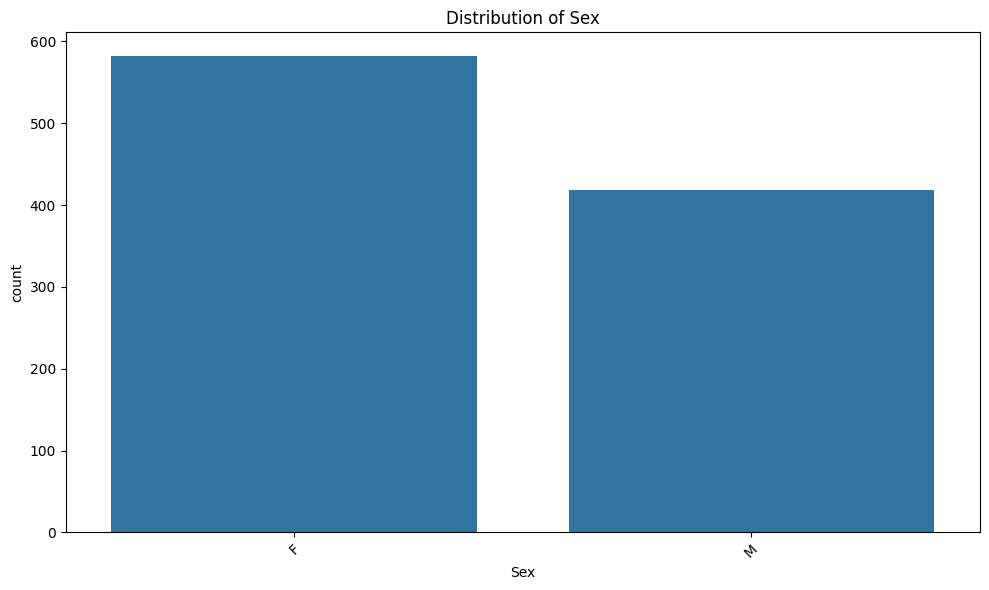

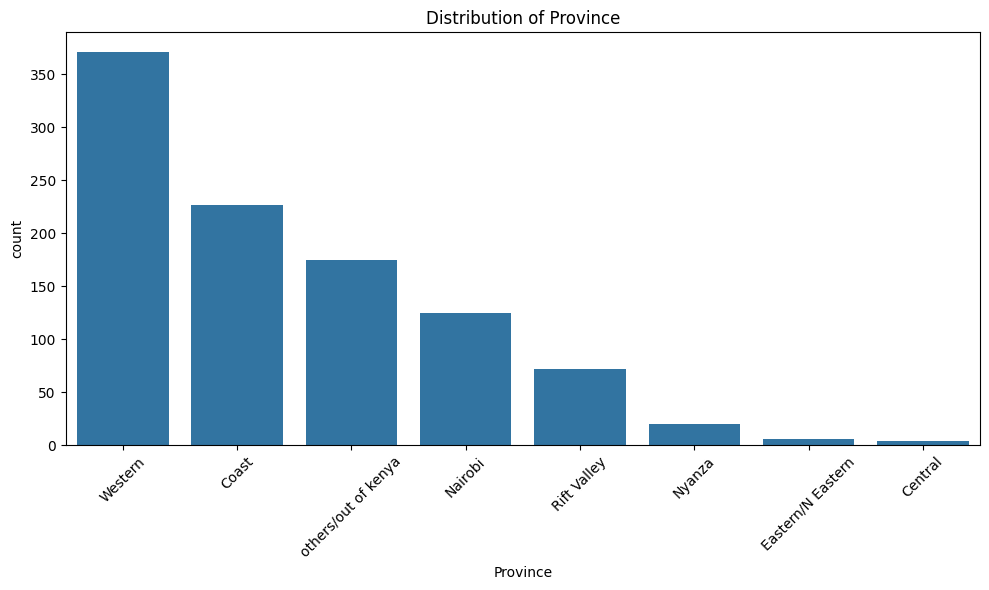

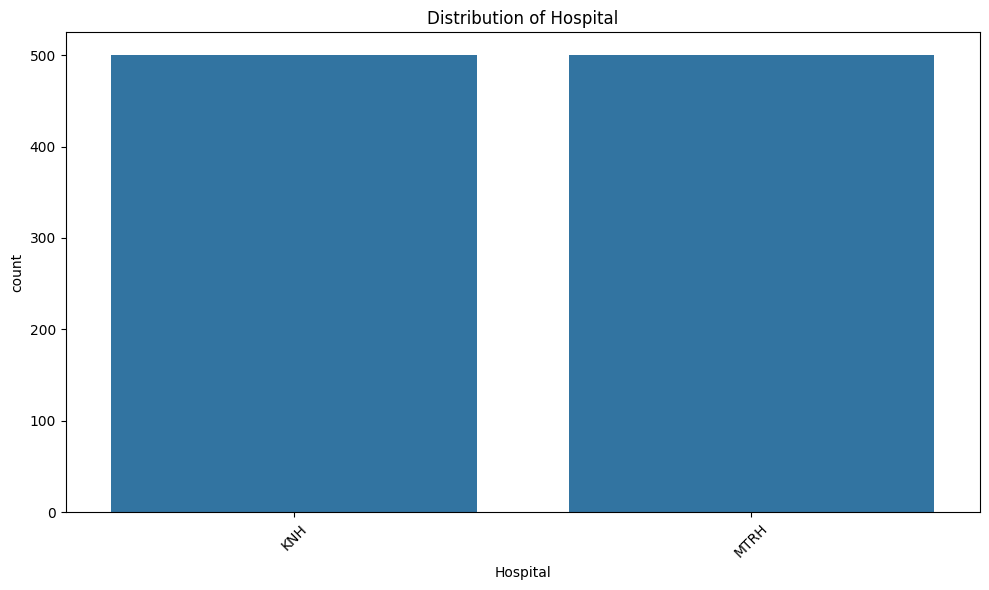

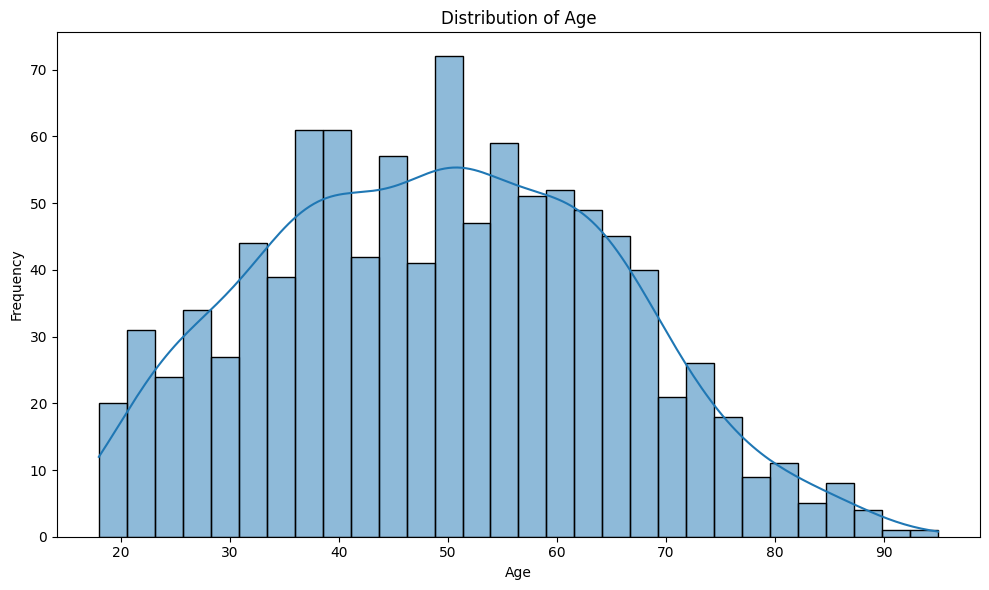

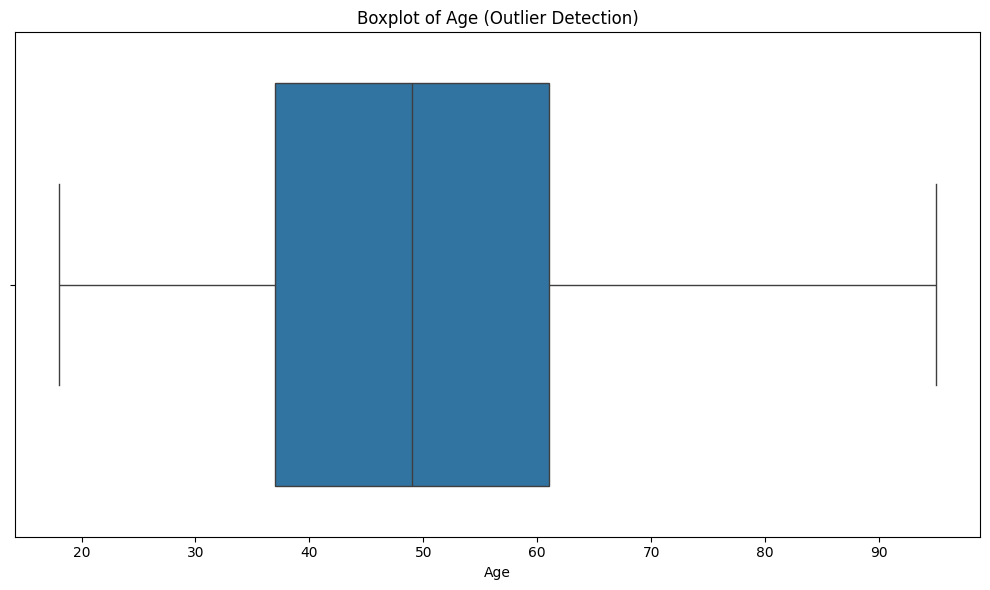

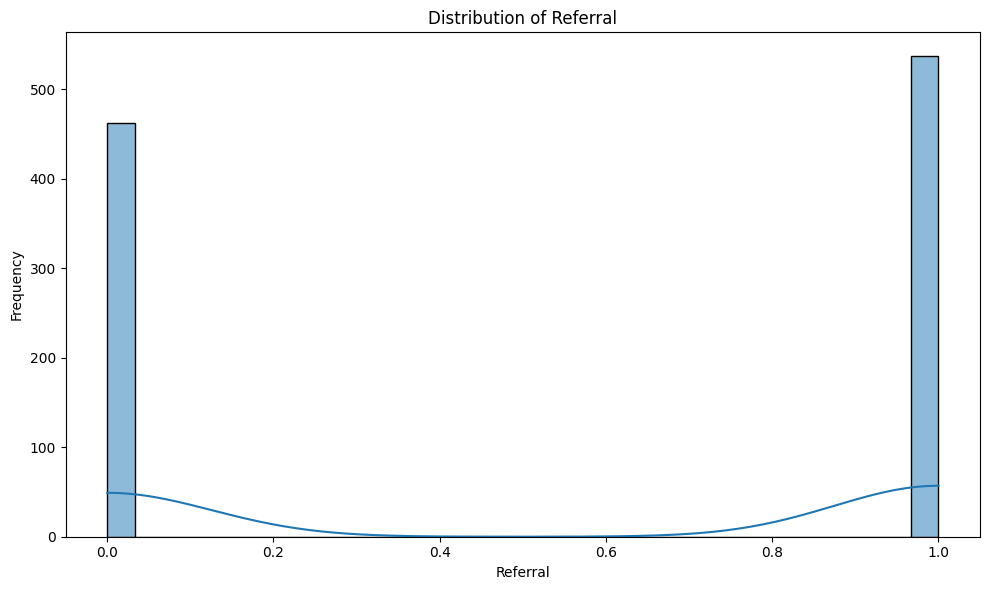

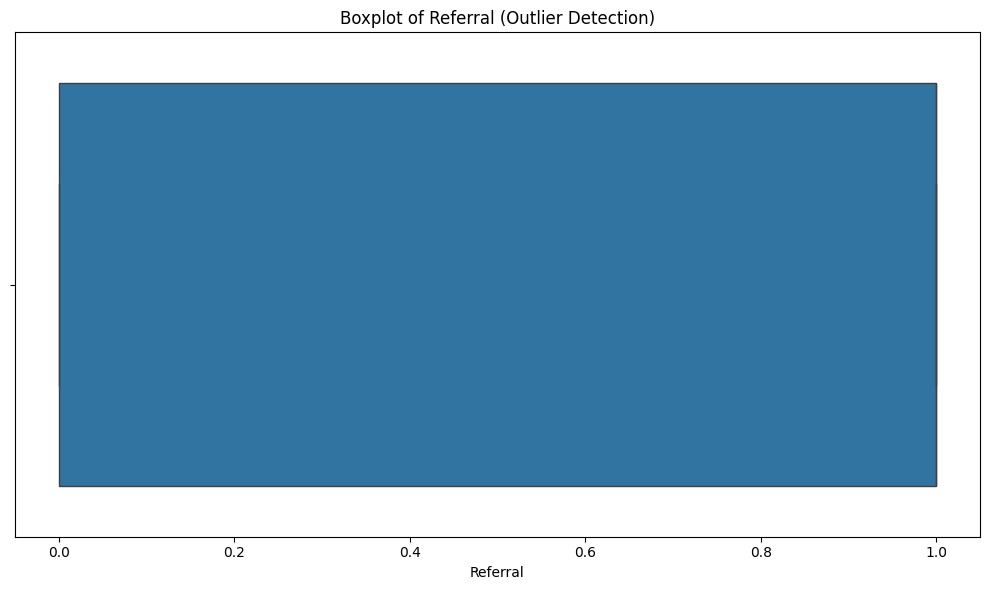

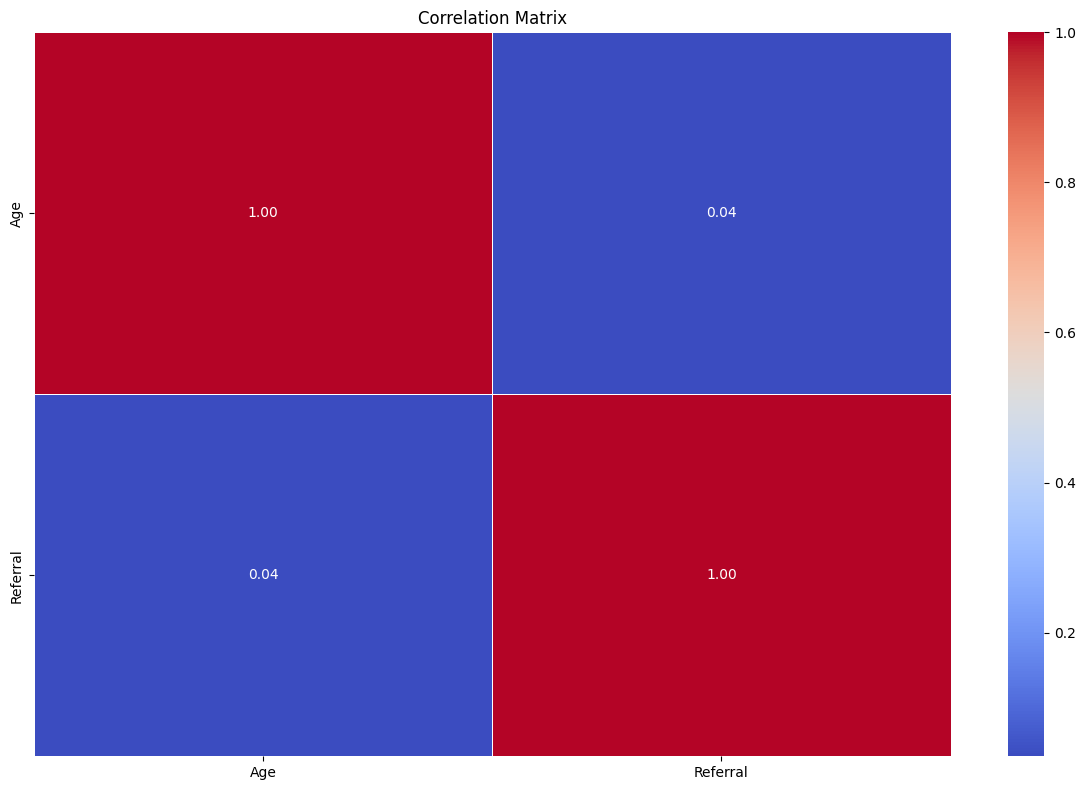

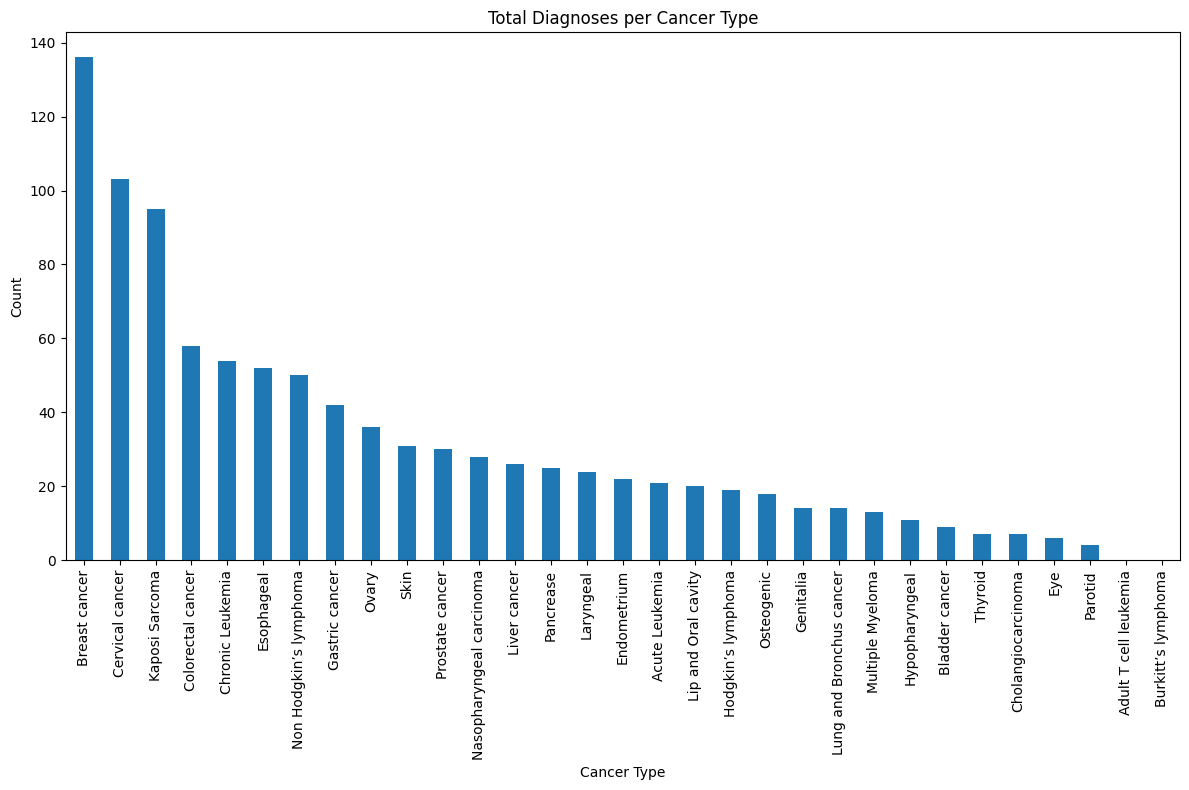

     PatientID Hospital  Age Sex      Residence             Province Referral  \
0     A001_KNH      KNH   67   M  Tharaka nithi              Nairobi        0   
1     A002_KNH      KNH   31   M          nyeri                Coast        0   
2     A003_KNH      KNH   62   M      kirinyaga                Coast        1   
3     A004_KNH      KNH   25   M          kisii  others/out of kenya        0   
4     A005_KNH      KNH   29   M       machakos              Nairobi        1   
..         ...      ...  ...  ..            ...                  ...      ...   
995  B150_MTRH     MTRH   18   F    UASIN GISHU              Western        0   
996  B151_MTRH     MTRH   25   F    UASIN GISHU              Western        1   
997  B152_MTRH     MTRH   50   F    UASIN GISHU              Western        1   
998  B153_MTRH     MTRH   44   F        BUNGOMA  others/out of kenya        1   
999  B154_MTRH     MTRH   36   M          NANDI              Western        1   

          Referred From  Ga

In [10]:
import pandas as pd

# Paths to the two files
file1_path = 'KNH_Data.xlsx'  # Replace with the actual path to the KNH file
file2_path = 'MTRH_Data.xlsx'  # Replace with the actual path to the MTRH file

# Load each file's 'Cleaned DB' sheet into DataFrames
df1 = pd.read_excel(file1_path, sheet_name='Cleaned DB')
df2 = pd.read_excel(file2_path, sheet_name='Cleaned DB')


# Standardizing column names in KNH to match MTRH
column_names_mtrh = df2.columns.tolist()  # Getting column names from MTRH
df1.columns = column_names_mtrh  # Applying these column names to KNH

# Concatenate the two DataFrames after standardizing column names
combined_df = pd.concat([df1, df2], ignore_index=True)

# Strip any leading or trailing whitespace in column names
combined_df.columns = combined_df.columns.str.strip()

# Rename the last five columns explicitly to 2008 through 2012
combined_df.columns.values[-5:] = [2008, 2009, 2010, 2011, 2012]



# Rename "Questionnaire No" to "PatientID"
combined_df.rename(columns={"Questionnaire No": "PatientID"}, inplace=True)

# Make "PatientID" unique by appending the "Hospital" name
combined_df["PatientID"] = combined_df["PatientID"].astype(str) + "_" + combined_df["Site"]

# Rename "Site" to "Hospital"
combined_df.rename(columns={"Site": "Hospital"}, inplace=True)

# Load the 'Coding' sheet from the KNH workbook to get the region mappings
coding_df = pd.read_excel(file1_path, sheet_name='Coding')

# Extract the regions and their codes from 'Unnamed: 14'
# We assume the codes are 1 to 7, and '0' for "others/out of kenya"
region_codes = list(range(8))
region_names = coding_df['Unnamed: 14'].iloc[1:9].values  # Adjusted to extract the relevant rows

# Create a dictionary to map Province codes to region names
province_mapping = dict(zip(region_codes, region_names))

# Map the 'Province' column in the combined DataFrame using the province_mapping
combined_df['Province'] = combined_df['Province'].map(province_mapping)

# Ensure "Breast cancer" column exists
if 'Breast cancer' in combined_df.columns:
    # Update records for MTRH (filter by 'Hospital' == 'MTRH')
    mtrh_mask = combined_df['Hospital'] == 'MTRH'
    combined_df.loc[mtrh_mask, 'Breast cancer'] = combined_df.loc[mtrh_mask, 'Breast cancer'].apply(
        lambda x: 0 if pd.isna(x) or str(x).strip() == "" else 1  # Blank/NaN = 0, any non-blank = 1
    )
    print("Updated 'Breast cancer' column for MTRH records.")
else:
    print("'Breast cancer' column not found in the DataFrame.")

# # Print all column names to verify the actual name of the 'Breast cancer' column
# print("Column names in the DataFrame:", combined_df.columns.tolist())

# Define the range of cancer columns to process
cancer_columns = combined_df.loc[:, 'Gastric cancer':'Multiple Myeloma'].columns

# Replace NaN with 0 and 'yes'/'Yes' (case-insensitive) with 1 in cancer columns
for column in cancer_columns:
    combined_df[column] = combined_df[column].fillna(0)  # Replace NaN with 0
    combined_df[column] = combined_df[column].apply(lambda x: 1 if x != 0 else 0)  # Replace any non-0 with 1

# Clean the 'OTHERS' column (column 'AN')
combined_df['OTHERS'] = combined_df['OTHERS'].fillna(0)  # Replace NaN with 0
combined_df[column] = combined_df[column].apply(lambda x: 1 if x != 0 else 0)  # Replace any non-0 with 1

# Define the range of cancer checking method columns (AP-AY)
method_columns = combined_df.loc[:, 'Method_Biopsy':'Mammogram'].columns

# Replace NaN with 0 and all other values with 1 in method columns
for column in method_columns:
    combined_df[column] = combined_df[column].fillna(0)  # Replace NaN with 0
    combined_df[column] = combined_df[column].apply(lambda x: 1 if x != 0 else 0)  # Replace any non-0 with 1

# Clean the 'others' column (AZ)
combined_df['others'] = combined_df['others'].fillna(0)  # Replace NaN with 0
combined_df['others'] = combined_df['others'].apply(lambda x: 1 if x != 0 else 0)  # Replace any non-0 with 1

# Ensure "Referral" column exists
if 'Referral' in combined_df.columns:
    # Create a mask for MTRH Referral column records
    mtrh_mask = combined_df['Hospital'] == 'MTRH'

    # Standardize the "Referral" column for MTRH records
    combined_df.loc[mtrh_mask, 'Referral'] = combined_df.loc[mtrh_mask, 'Referral'].str.strip().str.lower()  # Normalize text
    combined_df.loc[mtrh_mask, 'Referral'] = combined_df.loc[mtrh_mask, 'Referral'].replace(
        {'yes': 1, 'no': 0, '': 0, None: 0}  # Map values
    )
    combined_df.loc[mtrh_mask, 'Referral'] = combined_df.loc[mtrh_mask, 'Referral'].fillna(0).astype(int)  # Ensure numeric type
    print("Standardized 'Referral' column for MTRH records to contain 0 and 1 only.")
else:
    print("'Referral' column not found in the DataFrame.")

# Ensure the 'OTHERS' column exists
if 'OTHERS' in combined_df.columns:
    # Apply the condition where 'Hospital' is 'MTRH' and replace 'yes'/'Yes' with 1
    mtrh_mask = combined_df['Hospital'] == 'MTRH'
    combined_df.loc[mtrh_mask, 'OTHERS'] = combined_df.loc[mtrh_mask, 'OTHERS'].apply(
        lambda x: 1 if str(x).strip().lower() == 'yes' else x
    )
    print("Updated 'OTHERS' column for MTRH records to replace 'yes'/'Yes' with 1.")
else:
    print("'OTHERS' column not found in the DataFrame.")

# Fix trailing spaces in 'Sex' column
combined_df['Sex'] = combined_df['Sex'].str.strip()

# Verify the unique values in 'Sex'
print(f"Unique values in 'Sex' after cleaning: {combined_df['Sex'].unique()}")

# Handle the 'Specify' column (leave NaN as is, since it is valid based on domain knowledge)
print(f"Number of NaN values in 'Specify': {combined_df['Specify'].isna().sum()}")

# Standardize `2008-2012` columns: Replace NaN with 0 and anything else (e.g., 'yes', 'Yes') with 1
for year in range(2008, 2013):
    combined_df[year] = combined_df[year].apply(lambda x: 0 if pd.isna(x) else 1)

# Verify the unique values in `2008-2012` columns
for year in range(2008, 2013):
    print(f"Unique values in column {year}: {combined_df[year].unique()}")

# Validate the changes
print(combined_df.head())


# Validate Categorical Columns
categorical_columns = ['Sex', 'Province', 'Hospital']
for column in categorical_columns:
    print(f"Unique values in '{column}':")
    print(combined_df[column].unique(), "\n")

# Validate Numerical Columns
numerical_columns = ['Age', 'Referral']
for column in numerical_columns:
    print(f"Summary statistics for '{column}':")
    print(combined_df[column].describe(), "\n")

    # Check for outliers
    print(f"Outliers in '{column}':")
    print(combined_df[(combined_df[column] < 0) | (combined_df[column] > 100)])  # Adjust range as needed
    print("\n")
#*********************************************visualization of the cleaned dataset*********************************
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize categorical columns
def visualize_categorical_columns(df, categorical_columns):
    for column in categorical_columns:
        plt.figure(figsize=(10, 6))
        sns.countplot(data=df, x=column, order=df[column].value_counts().index)
        plt.title(f"Distribution of {column}")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

# Visualize numerical columns
def visualize_numerical_columns(df, numerical_columns):
    for column in numerical_columns:
        plt.figure(figsize=(10, 6))
        sns.histplot(data=df, x=column, kde=True, bins=30)
        plt.title(f"Distribution of {column}")
        plt.xlabel(column)
        plt.ylabel('Frequency')
        plt.tight_layout()
        plt.show()

        # Boxplot to detect outliers
        plt.figure(figsize=(10, 6))
        sns.boxplot(data=df, x=column)
        plt.title(f"Boxplot of {column} (Outlier Detection)")
        plt.tight_layout()
        plt.show()

# Correlation matrix heatmap for numerical columns
def visualize_correlation_matrix(df, numerical_columns):
    plt.figure(figsize=(12, 8))
    correlation_matrix = df[numerical_columns].corr()
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
    plt.title("Correlation Matrix")
    plt.tight_layout()
    plt.show()

# Bar plot for cancer diagnosis counts
def visualize_cancer_diagnosis_counts(df, cancer_columns):
    cancer_counts = df[cancer_columns].sum()
    plt.figure(figsize=(12, 8))
    cancer_counts.sort_values(ascending=False).plot(kind='bar')
    plt.title("Total Diagnoses per Cancer Type")
    plt.xlabel("Cancer Type")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

# Execute the visualization functions
categorical_columns = ['Sex', 'Province', 'Hospital']
numerical_columns = ['Age', 'Referral']
cancer_columns = combined_df.loc[:, 'Gastric cancer':'Multiple Myeloma'].columns

# Visualize distributions for categorical and numerical columns
visualize_categorical_columns(combined_df, categorical_columns)
visualize_numerical_columns(combined_df, numerical_columns)

# Correlation matrix for numerical columns
visualize_correlation_matrix(combined_df, numerical_columns)

# Visualize total diagnoses for each cancer type
visualize_cancer_diagnosis_counts(combined_df, cancer_columns)


#***********************************************Save****************************************************************
print(combined_df)
# # Save the combined DataFrame to a new Excel file
# output_path = 'Test_semiFinale.xlsx'
# combined_df.to_excel(output_path, index=False)
# print(f"Combined dataset with standardized columns saved to {output_path}")
